In this notebook I will verify various parts of the input for the workflow.

In [1]:
%run ../scripts/notebook_settings.py

In [2]:
meta_data_samples = pd.read_table("../data/metadata_with_x_missing.txt", sep=" ")
zarr_dir = "/faststorage/project/baboondiversity/data/PG_baboons_mmul_20_04_2021/callset.zarr/chr20"
#Opening the zarr data
callset = zarr.open_group(zarr_dir, mode="r")

Filter_Excesshet is not present, so I check ExcessHet. It gives phred-scaled p-values, so I choose a fitting number to investigate this.

In [3]:
Excesshet = callset["variants/ExcessHet"][:]

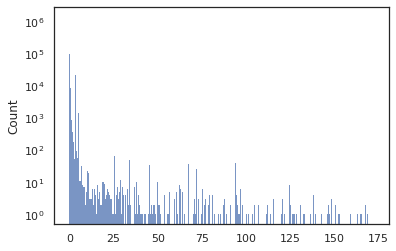

In [4]:
g = sns.histplot(Excesshet)
#g.set_xscale("log")
g.set_yscale("log")

In [5]:
sum(Excesshet > 20)

20683

In [6]:
len(Excesshet)

3577729

Checking the various variant fields

In [7]:
callset.tree()

Tree(nodes=(Node(disabled=True, name='/', nodes=(Node(disabled=True, name='calldata', nodes=(Node(disabled=Tru…

Mutrate normalization across chromosomes

In [8]:
dir_name = "steps/subcynocephalus_intro/"
path = "../"+dir_name+"mutrate_chr{}_intermediate.txt"
chromosome_numbers = ['{}'.format(x) for x in range(1, 21)] + ['X']
segregating_list = []
call_list = []
for chromosome in chromosome_numbers:
    mut_chrom_df = pd.read_csv(path.format(chromosome), sep="\t",
                               names=["chrom", "start", "segregating", "call", "mutrate"], index_col=False)
    segregating_list.extend(mut_chrom_df["segregating"])
    call_list.extend(mut_chrom_df["call"])
genomic_mut_rate = sum(segregating_list)/sum(call_list)
for chromosome in chromosome_numbers:
    mut_chrom_df = pd.read_csv(path.format(chromosome), sep="\t",
                               names=["chrom", "start", "segregating", "call", "mutrate"], index_col=False)
    mut_chrom_df["mut_rate"] = (mut_chrom_df.assign(start_big_window = (mut_chrom_df["start"]/1000000).astype(int))
                                .groupby("start_big_window", group_keys=False)
                                .apply(lambda x : ((x["start"]+1)/(x["start"]+1)) *  np.sum(x["segregating"])/np.sum(x["call"]) / genomic_mut_rate  )
                                .fillna(0))

In [9]:
genomic_mut_rate = sum(segregating_list)/sum(call_list)

<AxesSubplot:ylabel='Count'>

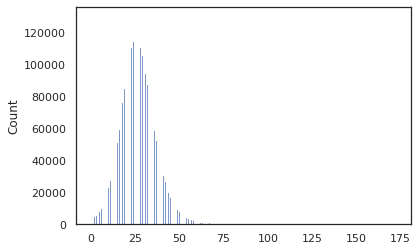

In [10]:
sns.histplot(segregating_list)

In [11]:
mut_chrom_df["mutrate"].mean()

0.9989022940327241

<AxesSubplot:xlabel='start', ylabel='mutrate'>

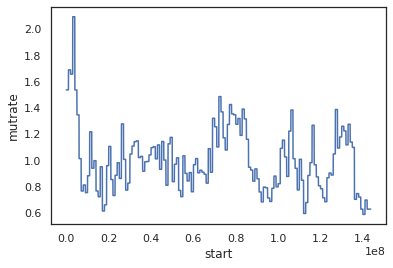

In [12]:
sns.lineplot(data=mut_chrom_df, x="start", y="mutrate")

Consensus HMM for every individual

In [13]:
ingroup_ids = meta_data_samples.loc[meta_data_samples.Species == "papio"].callset_index.values
ingroup_names = meta_data_samples.loc[meta_data_samples.Species == "papio"].PGDP_ID.values
outgroup_ids = meta_data_samples.loc[(meta_data_samples.Species != "papio") &
                                     (meta_data_samples.Species != "gelada")].callset_index.values
dir_name = "papio_intro/"

In [44]:
path = "../"+dir_name+"chr{}/{}.chr{}_trained.hmm"
def mean(l):
    return sum([float(x) for x in l])/len(l)
for ID in ["PD_0401"]:
    s1, t1, t2, t3, t4, e1, e2, ID_l, chrom_l = [], [], [], [], [], [], [], [], []
    for chromosome in chromosome_numbers:
        with open(path.format(chromosome, ID, chromosome)) as f:
            lines = f.readlines()
        hmm_t = []
        for l in lines[7].strip()[14:].split(","):
            hmm_t.append(l.strip("]["))
        t1.append(hmm_t[0]), t2.append(hmm_t[1]), t3.append(hmm_t[2]), t4.append(hmm_t[3])
        hmm_e = (lines[10].strip()[12:].strip("[]").split(","))
        s1.append(lines[4].strip()[25:].strip("[]").split(",")[0])
        e1.append(hmm_e[0]), e2.append(hmm_e[1])
        ID_l.append(ID)
        chrom_l.append(chromosome)
    with open("../papio_intro/{}".format(ID) + '.hmm','w') as out:
        out.write('# State names (only used for decoding)\n')
        out.write("states = ['Baboon','Archaic']\n\n")

        out.write('# Initialization parameters (prob of staring in states)\n')
        out.write("starting_probabilities = {values}\n\n".format(values = [mean(s1), 1-mean(s1)]))

        out.write('# transition matrix\n')
        out.write("transitions = [[{},{}],[{},{}]]\n\n".format(mean(t1),mean(t2),mean(t3),mean(t4)))
        
        out.write('# emission matrix (poisson parameter)\n')
        out.write("emissions = {values}\n".format(values = [x for x in [mean(e1), mean(e2)]]))
        
d = {"t1": t1, "t2": t2,"t3": t3,"t4": t4,"e1": e1,"e2": e2}
hmm_df = pd.DataFrame(data=d)
hmm_df = hmm_df.astype("float")
hmm_df["ID"] = ID_l
hmm_df["chrom"] = chrom_l

In [22]:
for ID in hmm_df["ID"].unique():
    ID_df = hmm_df.loc[hmm_df["ID"] == ID]
    print(ID_df["e2"].mean(), ID_df["e2"].median())
    

1.367846387597666 1.1317560043945636
1.3101861487584874 1.1744737296303638
1.3759956580065709 1.1073573954844425
1.379484654167629 1.221288417051987
1.3689724667302188 1.1607252043165506
1.3839573921901838 1.0900439537261122
1.3891408822217677 1.2313109071446267
1.2950930107433714 0.9877615669378729
1.3152114830045338 1.0572858208454974
1.3806006945052252 1.1958790704622233
1.4172931369730275 1.2034562938758724
1.4039468379623972 1.2597146968776824
